## $Y_{n+1}$
Uses $X_{n+1}, Y_n, Z_n, B_{\theta n}, B_{\psi  n-2},
\iota_{(n-2)/2 \text{or} (n-3)/2}, B_{\alpha  n/2 \text{or} (n-1)/2}$

$Y_{n+1}$ is given by (conv(a) + conv(b)@dchi)@Yn+1 = RHS - LHS(Yn+1 = 0)

Under-determined solve is neeX_coef_cpded.

## $Y_{n}$
Uses $X_{n}, Y_{n-1}, Z_{n-1}, B_{\theta n-1}, B_{\psi  n-3},
\iota_{(n-3)/2 \text{or} (n-4)/2}, B_{\alpha  (n-1)/2 \text{ or } (n-2)/2}$

In [1]:
# This file implements and tests recursion relations
import numpy as np
import timeit
import scipy.signal
from matplotlib import pyplot as plt
from numba import jit, njit, prange
from numba import complex128, int64    # import jit value types
from functools import lru_cache # import functools for caching
import warnings

# for importing parsed codes
import sys
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/MHD_parsed/')
sys.path.insert(1,'/Users/lanke/Desktop/Second year project/Code/python_source/')
from chiphifunc import *
from math_utilities import *
from chiphiepsfunc import *
from chiphifunc_test_suite import *
from recursion_relations import *
debug_path = '/Users/lanke/Desktop/Second year project/Code/test_data_eduardo/'

Detected 16 CPU's. Setting n_jobs to #CPU/2.


Axis shape:


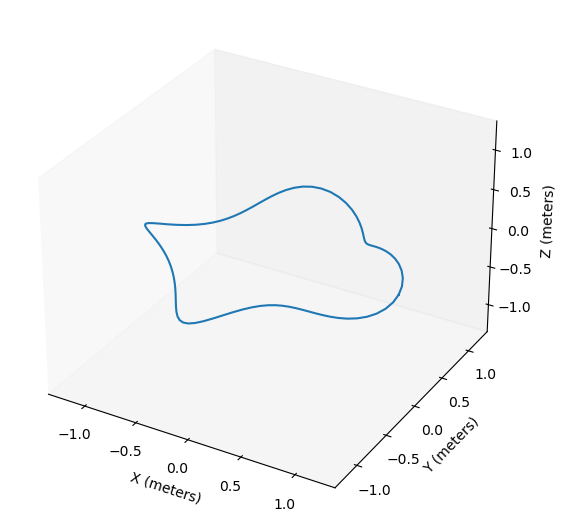

0

In [2]:
# No B theta
B_psi_coef_cp, B_theta_coef_cp, \
    Delta_coef_cp, p_perp_coef_cp,\
    X_coef_cp, Y_coef_cp, Z_coef_cp, \
    iota_coef, dl_p,\
    nfp, Xi_0, eta, \
    B_denom_coef_c, B_alpha_coef, \
    kap_p, tau_p = read_first_three_orders(
        debug_path+'5.4/', 
        R_array=[5,0,1,4,0.17,0,8,0.018191838304685660487880483060508,0,12,0.001420200653346571223467620370684,0,16,0.000059148767213264540889769427245426,0],
        Z_array=[5,0,0,4,0,0.15464423020448464507481389773602,8,0,0.017913837381820285621358834760031,12,0,0.0014893730073718687394179749361456,16,0,0.00006923943338841940945208031088498]
    )
B_theta_coef_cp = B_theta_coef_cp.zero_append()
B_theta_coef_cp[1]

In [3]:
import eval_ynp1

## Original

Difference


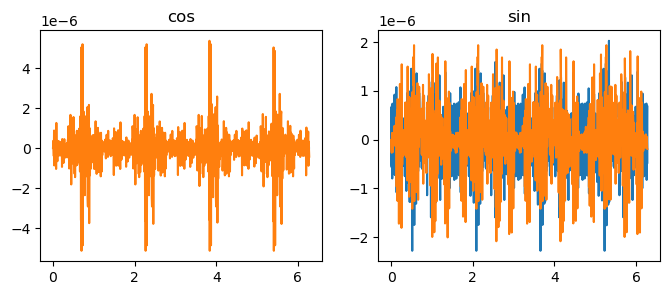

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             1.564e-07      
Worst:          2.629e+00       2.692e-06      
Std             nan             3.276e-07      
Total imaginary component
0.0



In [38]:
# This block solves for Yn using Yn+1 general formula. Just define a new method with 
# Y11s*sigma_tilde_n and n_eval inputs.
n_eval = 3

if n_eval%2==1:
    Yn1s_p, Yn1c_p = Y_coef_cp[n_eval].get_Yn1s_Yn1c()
    Y11s_p, Y11c_p = Y_coef_cp[1].get_Yn1s_Yn1c()

    # JUST FOR TESTING. ACTUAL VAL NEED TO COME FROM ODE
    # vai should be Yn1c = Y11s*sigma_tilde_n
    vai = Yn1c_p
else:
    vai = Y_coef_cp[n_eval].get_constant()

# Getting coeffs
# Both uses B_alpha0 and X1 only

coef_a = eval_ynp1.coef_a(n_eval-1, B_alpha_coef, X_coef_cp)
coef_b = eval_ynp1.coef_b(B_alpha_coef, X_coef_cp)

# Getting rhs-lhs
# for Yn to work, "n" must be subbed with n-1 here
yn_rhsmlhs = eval_ynp1.rhs_minus_lhs(n_eval-1,
    X_coef_cp,
    # Y_coef_cp.mask(n_eval) also works
    Y_coef_cp.mask(n_eval-1).zero_append(),
    Z_coef_cp,
    B_psi_coef_cp,
    B_theta_coef_cp,
    B_alpha_coef,
    kap_p, dl_p, tau_p,
    iota_coef)

# Solving (conv(a) + conv(b)@dchi)@Yn+1 = RHS - LHS(Yn+1 = 0) 
Yn_test = ChiPhiFunc.solve_underdet_degen(\
                                    Y_mode=True,
                                    v_source_A=coef_a, 
                                    v_source_B=coef_b,
                                    v_rhs=yn_rhsmlhs,
                                    rank_rhs=n_eval, # Yn has n+1 dof. So, RHS must have n dof.
                                    i_free=0, # (dummy) 
                                    vai=vai,
                                    )
compare_chiphifunc(Yn_test, Y_coef_cp[n_eval])

phi (1000,)
modesin (2,)
modecos (2,)
np.real(fourier.content)[len(fourier.content)//2+1:] (2, 1000)


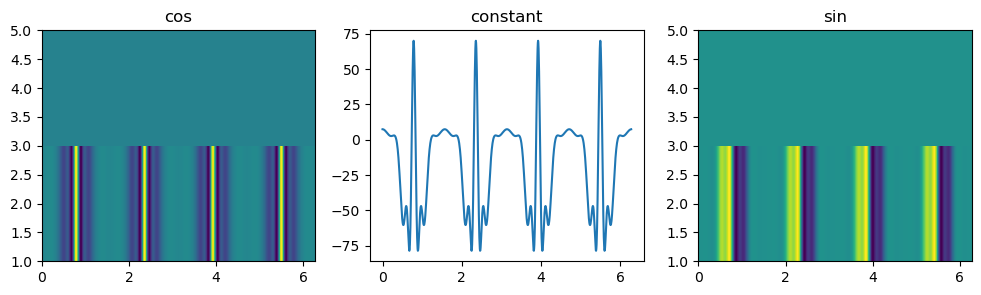

In [39]:
yn_rhsmlhs.display_content(colormap_mode=True)

## Solving $Y_{n}$order by order
The convolution matrices for $Y_n$ actually looks quite simple. Since the top and bottom elements are
not coupled to anything else, we can solve for them first.

$a = -\frac{(n+1)}{2} B_{\alpha 0}\frac{dX_1}{d\chi}$, is purely imaginary;

$b = \frac{B_{\alpha 0} X_1}{2}$, is purely real.

Note that the sum of dchi and regular terms will have 2 identical real components and 2 opposite 
imaginary components. See Loop original.ipynb.

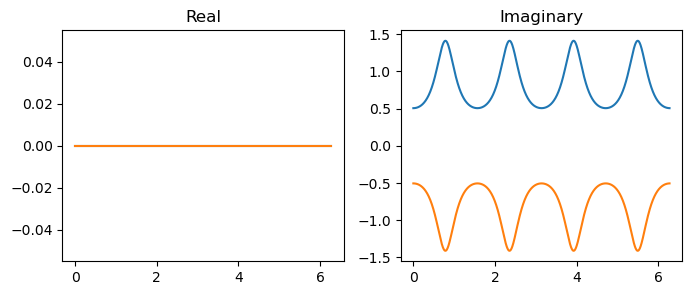

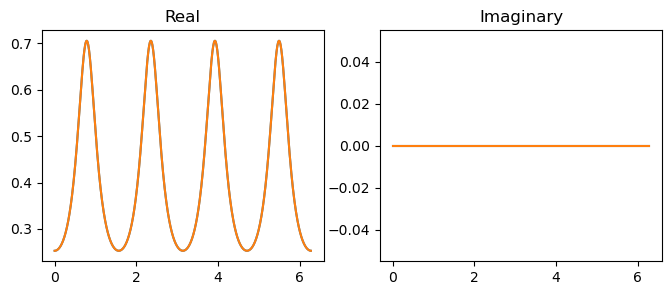

In [5]:
coef_a.display_content(fourier_mode=False)
coef_b.display_content(fourier_mode=False)

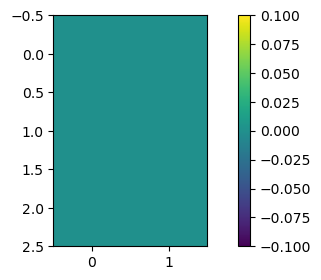

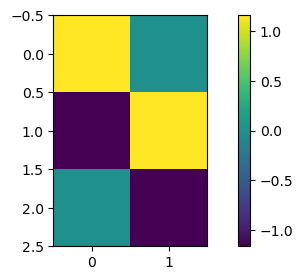

In [6]:
conv_example = conv_matrix(coef_a.content[:,150], 4-2)
plt.imshow(np.real(conv_example))
plt.colorbar()
plt.show()
plt.imshow(np.imag(conv_example))
plt.colorbar()
plt.show()

In [7]:
# For solving Y component by component.
# For a coefficient coeff[:,phi], define R, I, Cr and Ci s.t.
# R[phi] * Cr = np.real(conv_matrix(coeff[:,phi], n-2))
# I[phi] * Ci = np.imag(conv_matrix(coeff[:,phi], n-2))
# Cr =
# 1  0  0 
# 1  1  0
# 0  1  1
# 0  0  1 ...
# Ci =
#-1  0  0 
# 1 -1  0
# 0  1 -1
# 0  0  1 ...
def coeff_to_RI(coeff):
    if coeff==0:
        return(np.array([0]),np.array([0]))
    if not isinstance(coeff, ChiPhiFunc):
        raise TypeError('coeff_to_RI input must be ChiPhiFuncs')
    if coeff.get_shape()[0]!=2:
        raise TypeError('coeff_to_RI input must have exacty 2 chi components')
    R = np.real(coeff.content[1])
    I = np.imag(coeff.content[1])
    return(R,I)

In [33]:
# Solves some upper and lower edge components of x from 
# coeff * x 
# + coeff_dc * x.dchi()
# + coeff_dp * x.dphi()
# = RHS_chiphifunc
# num_comp_tot is the number of components in X. 
# NOTE: RHS_chiphifunc will be clipped with cap_m to 
# num_comp_tot + (maximum number of components in the three coefficients)-1.
# num_comp_to_solve is the number of edge component pairs to solve.
# where all coeffs are either 2-component ChiPhiFuncs or zeros.
# using provided RHS_chiphifunc.
def solve_by_component(RHS_chiphifunc, num_comp_tot, num_comp_to_solve, coeff=0, coeff_dc=0, coeff_dp=0):
    
    if num_comp_to_solve*2>num_comp_tot:
        raise ValueError('num_comp_to_solve*2 should be smaller than num_comp_tot.')
    
    if not isinstance(RHS_chiphifunc, ChiPhiFunc):
        raise TypeError('solve_by_component must have ChiPhiFunc as RHS')
    
    if coeff==0 and coeff_dc==0 and coeff_dp==0:
        raise ValueError('solve_by_component must have at least 1 non-zero coeff')
        
    # Used to measure the size of coeffs
    coeff_max_size = 0
    if isinstance(coeff, ChiPhiFunc):
        coeff_max_size = max(coeff_max_size, coeff.get_shape()[0])
    if isinstance(coeff_dp, ChiPhiFunc):
        coeff_max_size = max(coeff_max_size, coeff_dp.get_shape()[0])
    if isinstance(coeff_dc, ChiPhiFunc):
        coeff_max_size = max(coeff_max_size, coeff_dc.get_shape()[0])
    
    if coeff_max_size < 2:
        raise ValueError('All coeffs are constants or chi-independent.')

    len_phi = RHS_chiphifunc.get_shape()[1]
    m_cap_rhs = coeff_max_size + num_comp_tot - 1
    R, I = coeff_to_RI(coeff)
    R_dc, I_dc = coeff_to_RI(coeff_dc)
    R_dp, I_dp = coeff_to_RI(coeff_dp)
    
    # Blank array for B_theta
    x_out = np.zeros((num_comp_tot, len_phi), dtype = np.complex128)

    # Converting the form to
    # Ax+Bx' = f
    m_prev = num_comp_tot-1 # current mode being evaluated (mode of the outmost comps)
    A_minus_plus = np.array([(R - 1j*I) - 1j*(m_prev)*(R_dc - 1j*I_dc),
                             (R + 1j*I) + 1j*(m_prev)*(R_dc + 1j*I_dc)])
    B_minus_plus = np.array([(R_dp - 1j*I_dp),
                             (R_dp + 1j*I_dp)])
    f_minus_plus = np.array([RHS_chiphifunc.content[0],
                            RHS_chiphifunc.content[-1]])
    
    print('A_minus_plus')
    plt.plot(A_minus_plus.T)
    plt.show()
    print('f_minus_plus')
    plt.plot(f_minus_plus.T)
    plt.show()
    
    if np.all(B_minus_plus == 0):
        x_sln = f_minus_plus/A_minus_plus
    else:
        x_sln,_ = solve_integration_factor(coeff = A_minus_plus, 
                             coeff_dp = B_minus_plus, 
                             f = f_minus_plus, integral_mode = 'spline')
    print('x_sln', x_sln.shape)
    x_out[0] = x_sln[0]
    x_out[-1] = x_sln[-1]

    # (num_comp_to_solve > 4 or 5, there're more components to solve
    # for than the top and bottom 2)
    # Solves the equation 
    # A_curr x + B_curr x' + A_prev x_prev + B_prev x_prev' = f_curr
    if num_comp_to_solve>1: 
        print('Solving for inner components')
        x_sln_prev = x_sln
        print('x_sln_prev',x_sln_prev.shape)
        dp_x_sln_prev = ChiPhiFunc(x_sln_prev).dphi().content
        B_curr = B_minus_plus
        # number of component pair besides the outmost pairs
        for i in range(num_comp_to_solve-1): 
            # Coeffs of the previous order
            A_prev = np.array([(R + 1j*I) - 1j*(m_prev)*(R_dc + 1j*I_dc),
                               (R - 1j*I) + 1j*(m_prev)*(R_dc - 1j*I_dc)])
            B_prev = np.array([(R_dp + 1j*I_dp),
                               (R_dp - 1j*I_dp)])
            A_curr = np.array([(R - 1j*I) - 1j*(m_prev-2)*(R_dc - 1j*I_dc),
                               (R + 1j*I) + 1j*(m_prev-2)*(R_dc + 1j*I_dc)])
            # B_curr = B_minus_plus doesn't change
            f_curr = np.array([RHS_chiphifunc.content[1+i],
                               RHS_chiphifunc.content[-2-i]])\
                               - A_prev * x_sln_prev - B_prev * dp_x_sln_prev
            print('i',i)
            print('A_curr')
            plt.plot(A_curr.T)
            plt.show()
            print('f_curr')
            plt.plot(f_curr.T)
            plt.show()
            if np.all(B_curr == 0):
                x_sln_curr = f_curr/A_curr
            else:
                x_sln_curr,_ = solve_integration_factor(coeff = A_curr, 
                             coeff_dp = B_curr, 
                             f = f_curr)
            
            x_out[1+i] = x_sln_curr[0]
            x_out[-2-i] = x_sln_curr[-1]
            
            x_sln_prev = x_sln_curr
            dp_x_sln_prev = ChiPhiFunc(x_sln_prev).dphi().content
            m_prev = m_prev-2
            
    return(ChiPhiFunc(x_out))


A_minus_plus


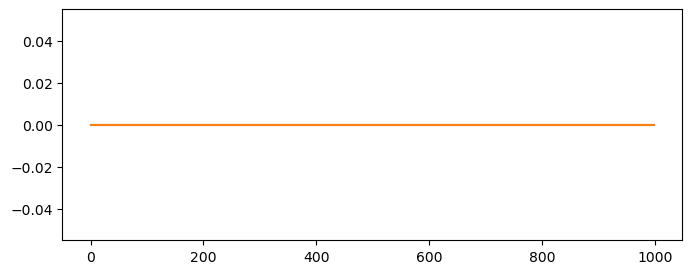

f_minus_plus


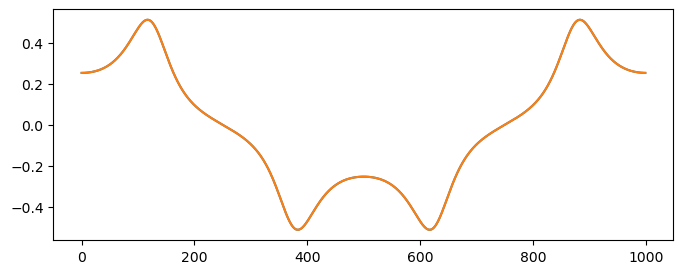

x_sln (2, 1000)
Solving for inner components
x_sln_prev (2, 1000)
i 0
A_curr


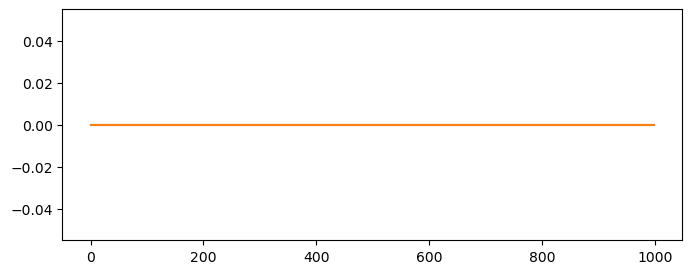

f_curr


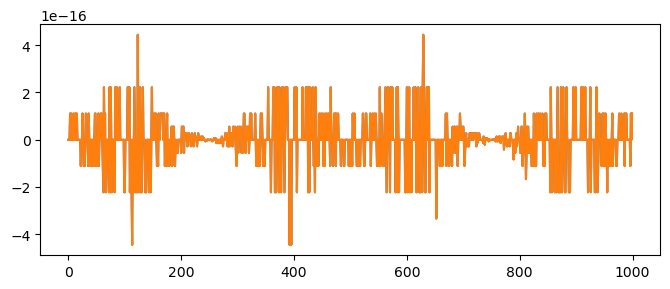

A


/var/folders/xd/b3ltq5c156d6vz7ynf6gkrhw0000gq/T/ipykernel_65993/1620231440.py:102: RuntimeWarning: divide by zero encountered in true_divide
  x_sln_curr = f_curr/A_curr
/var/folders/xd/b3ltq5c156d6vz7ynf6gkrhw0000gq/T/ipykernel_65993/1620231440.py:102: RuntimeWarning: invalid value encountered in true_divide
  x_sln_curr = f_curr/A_curr


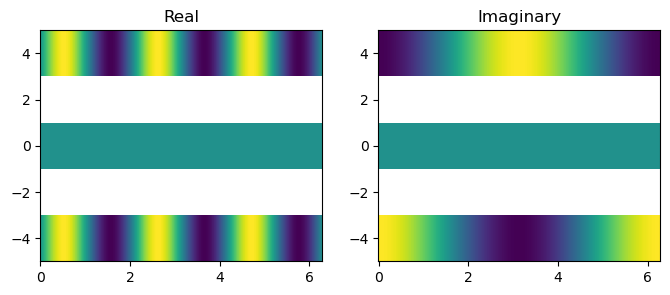

B


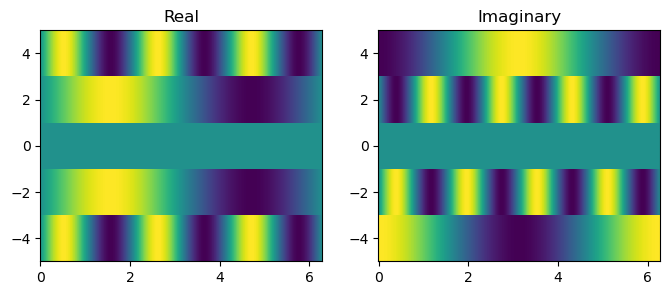

Difference


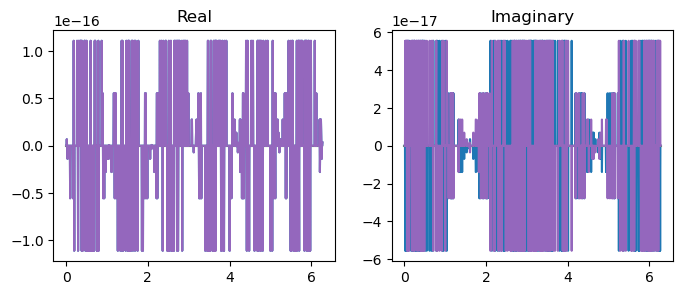

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             nan            
Worst:          inf             inf            
Std             nan             nan            
Total imaginary component
0.0



In [34]:
# testing:

rands1 = np.random.randint(5, size=20)
content1 = np.array([
    rands1[0]/10*np.sin(rands1[1]*points) + rands1[2]/10*np.cos(rands1[3]*points),
    rands1[4]/10*np.sin(rands1[5]*points) + rands1[6]/10*np.cos(rands1[7]*points),
    rands1[8]/10*np.sin(rands1[9]*points) + rands1[10]/10*np.cos(rands1[11]*points),
    rands1[12]/10*np.sin(rands1[13]*points) + rands1[14]/10*np.cos(rands1[15]*points),
    rands1[16]/10*np.sin(rands1[17]*points) + rands1[18]/10*np.cos(rands1[19]*points)
])*10
test1 = ChiPhiFunc(content1, fourier_mode = True)

test_RHS = coef_a*test1 \
    + coef_b*test1.dchi()

test_guess = solve_by_component(RHS_chiphifunc=test_RHS, num_comp_tot=5, num_comp_to_solve=2, coeff=coef_a, coeff_dc=coef_b, coeff_dp=0)
compare_chiphifunc(test_guess, test1, simple_mode = False, fourier_mode = False, colormap_mode=True)

A_minus_plus


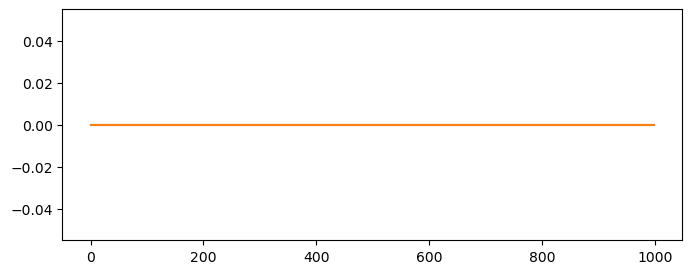

f_minus_plus


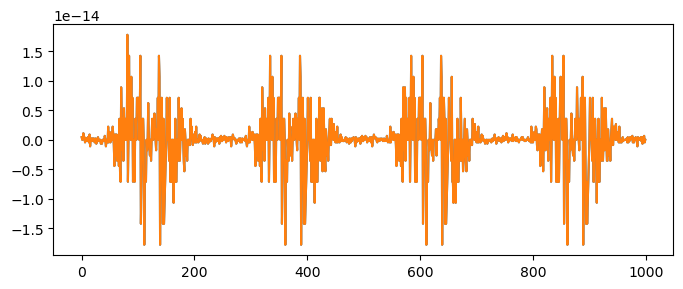

x_sln (2, 1000)
Solving for inner components
x_sln_prev (2, 1000)
i 0
A_curr


/var/folders/xd/b3ltq5c156d6vz7ynf6gkrhw0000gq/T/ipykernel_65993/1620231440.py:62: RuntimeWarning: divide by zero encountered in true_divide
  x_sln = f_minus_plus/A_minus_plus
/var/folders/xd/b3ltq5c156d6vz7ynf6gkrhw0000gq/T/ipykernel_65993/1620231440.py:62: RuntimeWarning: invalid value encountered in true_divide
  x_sln = f_minus_plus/A_minus_plus
/var/folders/xd/b3ltq5c156d6vz7ynf6gkrhw0000gq/T/ipykernel_65993/1620231440.py:93: RuntimeWarning: invalid value encountered in multiply
  - A_prev * x_sln_prev - B_prev * dp_x_sln_prev


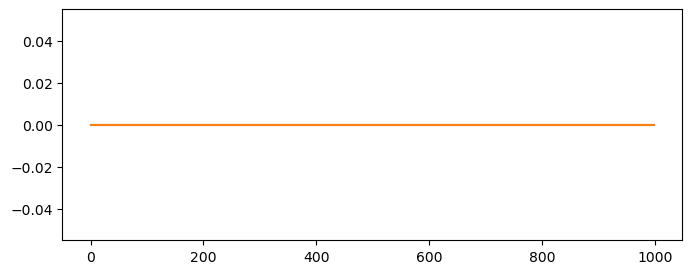

f_curr


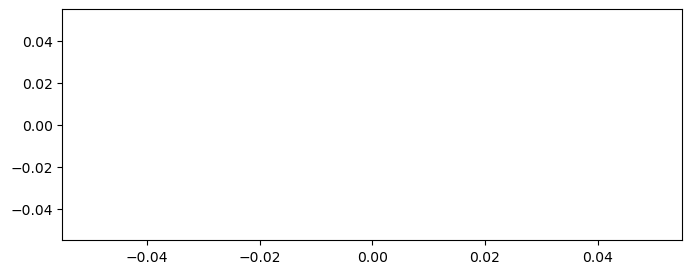

A


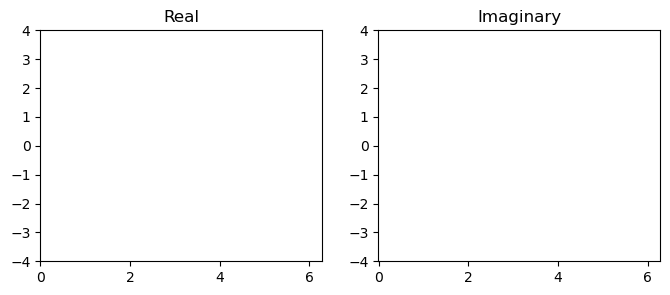

B


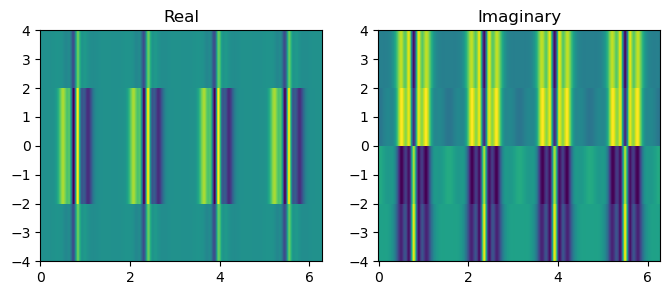

Difference


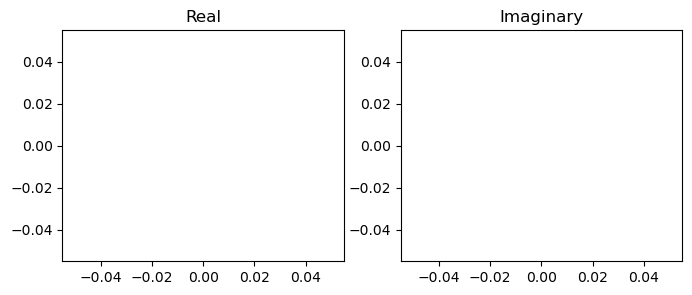

fractional errors b/w data and general formula
Error type:     Fractional      Total          
Avg:            nan             nan            
Worst:          inf             inf            
Std             nan             nan            
Total imaginary component
0.0



In [41]:
# This block solves for Yn using Yn+1 general formula. Just define a new method with 
# Y11s*sigma_tilde_n and n_eval inputs.
n_eval = 3

if n_eval%2==1:
    Yn1s_p, Yn1c_p = Y_coef_cp[n_eval].get_Yn1s_Yn1c()
    Y11s_p, Y11c_p = Y_coef_cp[1].get_Yn1s_Yn1c()

    # JUST FOR TESTING. ACTUAL VAL NEED TO COME FROM ODE
    # vai should be Yn1c = Y11s*sigma_tilde_n
    vai = Yn1c_p
else:
    vai = Y_coef_cp[n_eval].get_constant()

# Getting coeffs
# Both uses B_alpha0 and X1 only

coef_a = eval_ynp1.coef_a(n_eval-1, B_alpha_coef, X_coef_cp)
coef_b = eval_ynp1.coef_b(B_alpha_coef, X_coef_cp)

# Getting rhs-lhs
# for Yn to work, "n" must be subbed with n-1 here
yn_rhsmlhs = eval_ynp1.rhs_minus_lhs(n_eval-1,
    X_coef_cp,
    # Y_coef_cp.mask(n_eval) also works
    Y_coef_cp.mask(n_eval-1).zero_append(),
    Z_coef_cp,
    B_psi_coef_cp,
    B_theta_coef_cp,
    B_alpha_coef,
    kap_p, dl_p, tau_p,
    iota_coef)

# Solving (conv(a) + conv(b)@dchi)@Yn+1 = RHS - LHS(Yn+1 = 0) 
Yn_test = solve_by_component(
    RHS_chiphifunc=yn_rhsmlhs, 
    num_comp_tot=n_eval+1, num_comp_to_solve=(n_eval+1)//2, 
    coeff=coef_a, 
    coeff_dc=coef_b, 
    coeff_dp=0)

compare_chiphifunc(Yn_test, Y_coef_cp[n_eval], simple_mode = False, fourier_mode = False, colormap_mode = True)

In [36]:
coef_b.get_shape()

(2, 1000)